In [1]:
import pandas as pd
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sys


               x         y         z
0      -1.022461 -0.713660  2.071289
1      -1.023238 -0.711914  2.071289
2      -1.022461 -0.711914  2.073179
3      -1.022461 -0.713124  2.083008
4      -1.023661 -0.711914  2.083008
...          ...       ...       ...
620519  0.987305 -0.178711  0.839514
620520  0.999023 -0.131836  0.841960
620521  1.002353 -0.125977  0.840820
620522  1.000830 -0.120117  0.840820
620523  0.641602  0.588867  1.032357

[620524 rows x 3 columns]
torch.Size([620524, 1])
torch.Size([620524, 1])
torch.Size([620524, 1])


<ipython-input-2-5d15e6dbb889>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection='3d')


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (620524, 1)

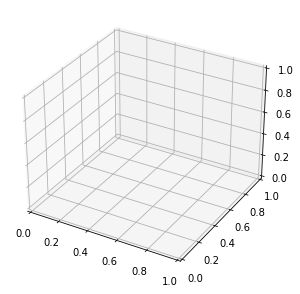

In [2]:
pcd = o3d.io.read_point_cloud("realsensedata.ply")
xmin, xmax, ymin, ymax, zmin, zmax = -10, 20, -10, 20, -10, 20
cmin, cmax = 0, 2
fig = plt.figure()
point = pd.DataFrame(np.asarray(pcd.points))
point.rename(columns={0:'x', 1:'y', 2:'z'}, inplace=True)

print(point)


x = torch.from_numpy(point['x'].values).unsqueeze(dim=1).float()
y = torch.from_numpy(point['y'].values).unsqueeze(dim=1).float()
z = torch.from_numpy(point['z'].values).unsqueeze(dim=1).float()
print(x.shape)
print(y.shape)
print(z.shape)
fig.set_size_inches(5, 5)
plt.scatter(x, y)
ax = plt.axes(projection='3d')
surf = ax.contour3D(x, y, z, 50, cmap=cm.coolwarm)

In [1]:
pcd = o3d.io.read_point_cloud("realsensedata.ply")
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True))
    
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
o3d.visualization.ViewControl.set_zoom(vis.get_view_control(), 0.8)
vis.run()
   

NameError: name 'o3d' is not defined

In [11]:
import open3d as o3d
import numpy as np
import sys
import copy

def visualization(data):
    if data is None:
        print('data load faile')
        sys.exit()
    for i in range(0,len(data)):
        vis = o3d.visualization.Visualizer()
        obb = data[i].get_oriented_bounding_box()
        vis.create_window()
        vis.add_geometry(obb)
        vis.add_geometry(data[i])
        o3d.visualization.ViewControl.set_zoom(vis.get_view_control(), 0.8)
        vis.run()


    
def plane_detection():
    data = []
    pcd = o3d.io.read_point_cloud("realsensedata.ply")
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                             ransac_n=3,
                                             num_iterations=1000)


    [a, b, c, d] = plane_model
    print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([0, 0, 1.0])

    outlier_cloud = pcd.select_by_index(inliers, invert=True)

    ###############
    plane2_model, inliers2 = outlier_cloud.segment_plane(distance_threshold=0.01,
                                                         ransac_n=3,
                                                         num_iterations=1000)
    [a, b, c, d] = plane2_model
    print(f"Plane equation2: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")
    
    inlier2_cloud = outlier_cloud.select_by_index(inliers2)
    inlier2_cloud.paint_uniform_color([0, 1.0, 0])

    outlier2_cloud = outlier_cloud.select_by_index(inliers2, invert=True)

    ################
    plane3_model, inliers3 = outlier2_cloud.segment_plane(distance_threshold=0.01,
                                                          ransac_n=3,
                                                          num_iterations=1000)
    [a, b, c, d] = plane3_model
    print(f"Plane equation3: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")
    inlier3_cloud = outlier2_cloud.select_by_index(inliers3)
    inlier3_cloud.paint_uniform_color([1.0, 0, 0])


    data.append(inlier_cloud)
    data.append(inlier2_cloud)
    data.append(inlier3_cloud)
   
    planbox1 = inlier_cloud.get_oriented_bounding_box()
    planbox2 = inlier2_cloud.get_oriented_bounding_box()
    planbox3 = inlier3_cloud.get_oriented_bounding_box()
    vis = o3d.visualization.Visualizer()
    
    vis.create_window()
    vis.add_geometry(planbox1)
    vis.add_geometry(planbox2)
    vis.add_geometry(planbox3)
    vis.add_geometry(inlier_cloud)
    vis.add_geometry(inlier2_cloud)
    vis.add_geometry(inlier3_cloud)
    o3d.visualization.ViewControl.set_zoom(vis.get_view_control(), 0.8)
    vis.run()
   

plane_detection()




Plane equation: -0.03x + 0.92y + 0.39z + -0.92 = 0
Plane equation2: 0.95x + -0.23y + 0.23z + -1.18 = 0
Plane equation3: -0.39x + -0.61y + 0.69z + -2.22 = 0
